In [37]:
import sys
import os
from pathlib import Path
from glob import glob
from collections import defaultdict

import signac

import numpy as np
import pandas as pd
import scipy.spatial
import scipy.cluster.hierarchy

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')
%matplotlib inline

Add scripts path to notebook

In [9]:
scripts_path = '/'.join(str(Path().absolute()).split('/')[:-1])
sys.path.append(scripts_path)
print(scripts_path)

from utils.Hypersphere import fit_hypersphere

/Users/kelwang/Documents/projects/robust-surface-curvature


In [10]:
pr = signac.get_project(
    '/Volumes/glotzer/proteins_ebt'
) 

In [11]:
# for job in pr.find_jobs({"decoy": {"$regex": "2goo"}, "num_chains_tot": 2}):
#     print(job)
job = pr.open_job(id="733f45a1c01aaeed57b8616b9f3f1a40")

In [12]:
def unit_vector(x):
    return x/np.linalg.norm(x)

def unit_normal(v1, v2, v3):
    v1, v2, v3 = np.array(v1), np.array(v2), np.array(v3)
    v31 = v3 - v1
    v21 = v2 - v1
    cross = np.cross(v31/np.linalg.norm(v31), v21/np.linalg.norm(v21))
    return cross/ np.linalg.norm(cross)

In [20]:
vert_files = [f.split('/')[-1] for f in glob(job.fn("*.vert"))]
print(vert_files)

['r-l_12223.vert', 'r-l_12223_chain_C.vert', 'r-l_12223_chain_A.vert']


In [54]:
verts = np.genfromtxt(
    job.fn(vert_files[-1]),
    usecols=[0, 1, 2],
    skip_header=3
)

In [55]:
Z = scipy.cluster.hierarchy.linkage(verts, 'complete')

In [66]:
max_d = 6 # patch

In [67]:
clusters = scipy.cluster.hierarchy.fcluster(Z, max_d, criterion='distance')

In [68]:
curvature = defaultdict(list)
centroid = np.median(verts, axis=0)

In [69]:
dist = []
j = 0

for i in range(1, max(clusters) + 1):
    curv1_p = []
    curv2_p = []
    curv_m = fit_hypersphere(verts[clusters == i])
    ci = curv_m[1]
    count = []
    d_centroid = np.linalg.norm(centroid - ci)
    
    for x in verts[clusters == i]:
        d = np.linalg.norm(ci -  x)
        d_c = np.linalg.norm(centroid - x)
        if d_c > d_centroid:
            count.append(1)
            curv1_p.append(x)
        else:
            count.append(-1)
            curv2_p.append(x)
    
        A = (len(curv1_p) / len(verts[clusters == i]))
        B = (len(curv2_p) / len(verts[clusters == i]))
        
        for x in curv1_p:
            curvature[tuple(x)] = A * 100 / curv_m[0]
            
        for x in curv2_p:
            curvature[tuple(x)] = B * -100 / curv_m[0]

In [73]:
patch_verts = np.asarray(list(curvature.keys()))
patch_curvature = np.asarray(list(curvature.values()))

array([-17.58409445, -17.58409445, -17.58409445, ...,  -3.71214309,
        -3.71214309,  -3.71214309])

(-66.1317, -9.8403, 5.092700000000001, 54.2693)

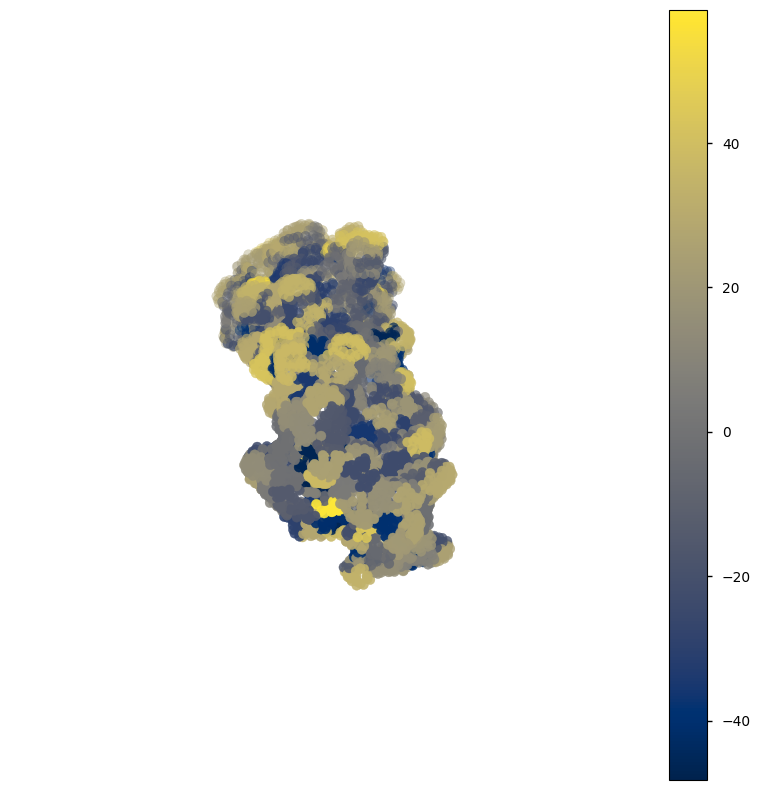

In [105]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

cb = ax.scatter(
    patch_verts[:, 0],
    patch_verts[:, 1],
    patch_verts[:, 2],
    c=patch_curvature,
    s=50,
    cmap="cividis"
)
plt.colorbar(cb)
ax.axis("off")